# CrossModelFabric class

`CrossModelFabric` - abstract fabric for easy crossvalidation

Notebook contains examples for `CrossLightgbmModel`, but there are `CrossXgboostModel` option as well!

* CrossModelFabric.fit() fits models for each fold with early_stopping. Finds optimal num_boost parameter
* CrossModelFabric.transform() - calculates OOF predictions for train data (with num_boost parameter)
* CrossModelFabric.predict() - calculates predictions test data (with num_boost parameter)
* CrossModelFabric.get_hyperopt_space() - returns hyperopt space
* CrossModelFabric.shap() - returns figure with barplot of avg shap values for all folds
* CrossModelFabric.shap_summary_plot() - returns figure with shap_summary for specific dataset of model[0]


## Imports

In [1]:
import pandas as pd
import os
import requests
import numpy as np
import yaml
import logging
from sklearn.metrics import roc_auc_score
from crosspredict.iterator import Iterator
from crosspredict.crossval import CrossLightgbmModel
logging.basicConfig(level=logging.INFO)

## Load data

In [2]:
file_url = 'https://boosters.pro/api/ch/files/pub/onetwotrip_challenge_train.csv'
file_path = '../tests/onetwotrip_challenge_train.csv'
if os.path.isfile(file_path)!=True:
    myfile = requests.get(file_url)
    open(file_path, 'wb').write(myfile.content)
    
df = pd.read_csv('../tests/onetwotrip_challenge_train.csv')


unique_clients = pd.Series(df['userid'].unique())
test_users = unique_clients.sample(frac=0.2,random_state=0)
val_idx = df['userid'].isin(test_users)
test = df[val_idx].copy()
train = df[~val_idx].copy()

## Parameters

In [3]:
feature_name = df.columns.values
feature_name = np.delete(feature_name, np.argwhere(feature_name == 'goal1'))
feature_name = np.delete(feature_name, np.argwhere(feature_name == 'orderid'))
feature_name = np.delete(feature_name, np.argwhere(feature_name == 'userid'))

params= {'bagging_fraction': 0.849285747554019,
  'bagging_freq': 5,
  'bagging_seed': 0,
  'boosting_type': 'gbdt',
  'data_random_seed': 0,
  'drop_seed': 0,
  'feature_fraction': 0.8212766928844304,
  'feature_fraction_seed': 0,
  'lambda_l1': 0.8955546599539566,
  'lambda_l2': 1.4423261095989717,
  'learning_rate': 0.03,
  'max_bin': 255,
  'max_depth': 43,
  'metric': 'auc',
  'min_data_in_leaf': 149,
  'min_sum_hessian_in_leaf': 1.804477623298885,
  'num_leaves': 363,
  'objective': 'binary',
  'seed': 0,
  'verbose': -1}

## Crossvalidation by `col_client` column (rows from each users goes in specific fold)

### fit model on train data

In [4]:
iter_df = Iterator(n_repeats=3,
                    n_splits=3,
                    random_state = 0,
                    col_client = 'userid',
                    cv_byclient=True)

model_class = CrossLightgbmModel(iterator=iter_df, 
                                 feature_name=feature_name,
                                params=params,
                                cols_cat = ['field3', 'field2', 'field11', 'field23', 'field18', 'field20'],
                                num_boost_round = 9999,
                                early_stopping_rounds = 50,
                                valid = True,
                                random_state = 0,
                                col_target = 'goal1',)
result = model_class.fit(train)

# `fit` method returns loss from optimal num_boost parameter
# optimal num_boost for cross validation:
# - removes roc_auc metrics if at least one fold stopped before (early_stopping)
# - calculates avg roc_auc on all folds on each num_boost
# - argmax value

Using RepeatedKFold by column group "userid"
INFO:crosspredict.crossval:{'bagging_fraction': 0.849285747554019, 'bagging_freq': 5, 'bagging_seed': 0, 'boosting_type': 'gbdt', 'data_random_seed': 0, 'drop_seed': 0, 'feature_fraction': 0.8212766928844304, 'feature_fraction_seed': 0, 'lambda_l1': 0.8955546599539566, 'lambda_l2': 1.4423261095989717, 'learning_rate': 0.03, 'max_bin': 255, 'max_depth': 43, 'metric': 'auc', 'min_data_in_leaf': 149, 'min_sum_hessian_in_leaf': 1.804477623298885, 'num_leaves': 363, 'objective': 'binary', 'seed': 0, 'verbose': -1}
INFO:crosspredict.crossval:REPEAT FOLDS 0 START
INFO:crosspredict.crossval:	CROSSVALIDATION FOLD 0 ENDS with best ROCAUC = 0.697301828294343
INFO:crosspredict.crossval:	CROSSVALIDATION FOLD 1 ENDS with best ROCAUC = 0.6972290051903695
INFO:crosspredict.crossval:	CROSSVALIDATION FOLD 2 ENDS with best ROCAUC = 0.7077976895321761
INFO:crosspredict.crossval:REPEAT FOLDS 1 START
INFO:crosspredict.crossval:	CROSSVALIDATION FOLD 0 ENDS with be

### predict on test data

In [5]:
# returns predctions from optimal num_boost parameter (mean prediction from all models)
model_class.predict(test)

3         0.029087
6         0.021241
9         0.024901
12        0.009496
14        0.011062
            ...   
196039    0.021094
196042    0.027103
196045    0.010621
196046    0.012720
196048    0.021069
Name: PREDICT, Length: 38859, dtype: float64

In [6]:
roc_auc_score(test['goal1'],model_class.predict(test))

0.7189406147162991

### predict on train data. (OOF - out of fold prediction)

In [7]:
model_class.transform(train)

# returns OOF predctions from optimal num_boost parameter 
# (mean prediction if n_repeats>1, because there are more than one model that can predict each row)

0         0.018500
1         0.031481
2         0.011632
4         0.020763
5         0.016286
            ...   
196051    0.018088
196052    0.012538
196053    0.019197
196054    0.042271
196055    0.014101
Name: PREDICT, Length: 157197, dtype: float64

In [8]:
roc_auc_score(train['goal1'],model_class.transform(train))

0.7083991804553007

### hyperopt hyperparameter optimisation

In [9]:
# get standart hyperopt space for lightgbm
space = model_class.get_hyperopt_space()

In [16]:
space

{'num_leaves': <hyperopt.pyll.base.Apply at 0x7f89bec70e90>,
 'max_depth': <hyperopt.pyll.base.Apply at 0x7f89bec6c2d0>,
 'min_data_in_leaf': <hyperopt.pyll.base.Apply at 0x7f89bec6c4d0>,
 'feature_fraction': <hyperopt.pyll.base.Apply at 0x7f89bec6c650>,
 'bagging_fraction': <hyperopt.pyll.base.Apply at 0x7f89bec6c7d0>,
 'min_sum_hessian_in_leaf': <hyperopt.pyll.base.Apply at 0x7f89bec6c950>,
 'lambda_l1': <hyperopt.pyll.base.Apply at 0x7f89bec6cad0>,
 'lambda_l2': <hyperopt.pyll.base.Apply at 0x7f89bec6cc50>,
 'seed': 0,
 'feature_fraction_seed': 0,
 'bagging_seed': 0,
 'drop_seed': 0,
 'data_random_seed': 0,
 'verbose': -1,
 'bagging_freq': 5,
 'max_bin': 255,
 'learning_rate': 0.03,
 'boosting_type': 'gbdt',
 'objective': 'binary',
 'metric': 'auc'}

In [10]:
print(str(space['num_leaves']))

0 int
1   float
2     hyperopt_param
3       Literal{num_leaves}
4       quniform
5         Literal{300}
6         Literal{500}
7         Literal{1}


In [11]:
from hyperopt import fmin, hp, tpe, Trials, space_eval, STATUS_OK, STATUS_RUNNING
from hyperopt.pyll import scope

# get standart hyperopt space for lightgbm with custom options
space = model_class.get_hyperopt_space({'num_leaves': scope.int(hp.quniform('num_leaves', 100, 200, 1))})


In [12]:
print(str(space['num_leaves']))

0 int
1   float
2     hyperopt_param
3       Literal{num_leaves}
4       quniform
5         Literal{100}
6         Literal{200}
7         Literal{1}


In [13]:
iter_df = Iterator(n_repeats=1,
                    n_splits=3,
                    random_state = 0,
                    col_client = 'userid',
                    cv_byclient=True)

def score(params):
    cv_score = CrossLightgbmModel(iterator=iter_df, 
                                 feature_name=feature_name,
                                params=params,
                                cols_cat = ['field3', 'field2', 'field11', 'field23', 'field18', 'field20'],
                                num_boost_round = 9999,
                                early_stopping_rounds = 50,
                                valid = True,
                                random_state = 0,
                                col_target = 'goal1',)
    return cv_score.fit(df=train)

trials = Trials()
best = fmin(fn=score,
            space=space,
            algo=tpe.suggest,
            trials=trials,
            max_evals=2
            )
results = space_eval(space, best)
print(results)

  0%|          | 0/2 [00:00<?, ?trial/s, best loss=?]

Using RepeatedKFold by column group "userid"
INFO:hyperopt.tpe:build_posterior_wrapper took 0.002975 seconds
INFO:hyperopt.tpe:TPE using 0 trials
INFO:crosspredict.crossval:{'bagging_fraction': 0.9230857926783654, 'bagging_freq': 5, 'bagging_seed': 0, 'boosting_type': 'gbdt', 'data_random_seed': 0, 'drop_seed': 0, 'feature_fraction': 0.9920158580306366, 'feature_fraction_seed': 0, 'lambda_l1': 0.6803407372529847, 'lambda_l2': 0.3187092362014174, 'learning_rate': 0.03, 'max_bin': 255, 'max_depth': 53, 'metric': 'auc', 'min_data_in_leaf': 91, 'min_sum_hessian_in_leaf': 4.753894156420975, 'num_leaves': 119, 'objective': 'binary', 'seed': 0, 'verbose': -1}
INFO:crosspredict.crossval:REPEAT FOLDS 0 START
INFO:crosspredict.crossval:	CROSSVALIDATION FOLD 0 ENDS with best ROCAUC = 0.6917724736953605
INFO:crosspredict.crossval:	CROSSVALIDATION FOLD 1 ENDS with best ROCAUC = 0.6981503974145464
INFO:crosspredict.crossval:	CROSSVALIDATION FOLD 2 ENDS with best ROCAUC = 0.6998738725344477
INFO:cros

 50%|█████     | 1/2 [00:12<00:12, 12.80s/trial, best loss: -0.6963528220111866]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.004642 seconds
INFO:hyperopt.tpe:TPE using 1/1 trials with best loss -0.696353
INFO:crosspredict.crossval:{'bagging_fraction': 0.9905357561494915, 'bagging_freq': 5, 'bagging_seed': 0, 'boosting_type': 'gbdt', 'data_random_seed': 0, 'drop_seed': 0, 'feature_fraction': 0.8737863546856102, 'feature_fraction_seed': 0, 'lambda_l1': 0.975105842345082, 'lambda_l2': 1.6686950583315598, 'learning_rate': 0.03, 'max_bin': 255, 'max_depth': 13, 'metric': 'auc', 'min_data_in_leaf': 86, 'min_sum_hessian_in_leaf': 1.428615700376287, 'num_leaves': 152, 'objective': 'binary', 'seed': 0, 'verbose': -1}
INFO:crosspredict.crossval:REPEAT FOLDS 0 START
INFO:crosspredict.crossval:	CROSSVALIDATION FOLD 0 ENDS with best ROCAUC = 0.6985478224903406
INFO:crosspredict.crossval:	CROSSVALIDATION FOLD 1 ENDS with best ROCAUC = 0.7016942586308145
INFO:crosspredict.crossval:	CROSSVALIDATION FOLD 2 ENDS with best ROCAUC = 0.7102799688122039
INFO:crosspredict.crossval:{

100%|██████████| 2/2 [00:25<00:00, 12.76s/trial, best loss: -0.7022219455448453]
{'bagging_fraction': 0.9905357561494915, 'bagging_freq': 5, 'bagging_seed': 0, 'boosting_type': 'gbdt', 'data_random_seed': 0, 'drop_seed': 0, 'feature_fraction': 0.8737863546856102, 'feature_fraction_seed': 0, 'lambda_l1': 0.975105842345082, 'lambda_l2': 1.6686950583315598, 'learning_rate': 0.03, 'max_bin': 255, 'max_depth': 13, 'metric': 'auc', 'min_data_in_leaf': 86, 'min_sum_hessian_in_leaf': 1.428615700376287, 'num_leaves': 152, 'objective': 'binary', 'seed': 0, 'verbose': -1}


### .shap() method - returns dataframe with avg shap values from each model in crossvalidation and its std + barplot

Setting feature_perturbation = "tree_path_dependent" because no background data was given.
LightGBM binary classifier with TreeExplainer shap values output has changed to a list of ndarray


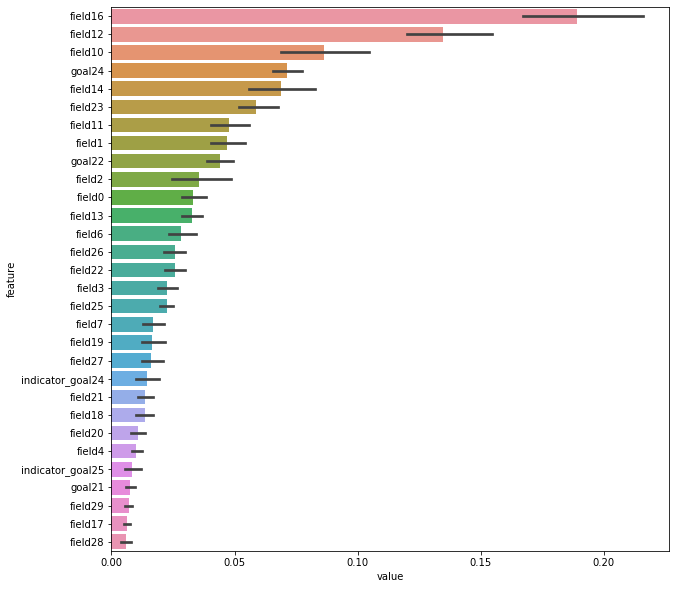

In [14]:
shap_df, fig = model_class.shap(train)

### .shap_summary_plot() returns figure of shap's summary_plot() from model[0] on any dataframe

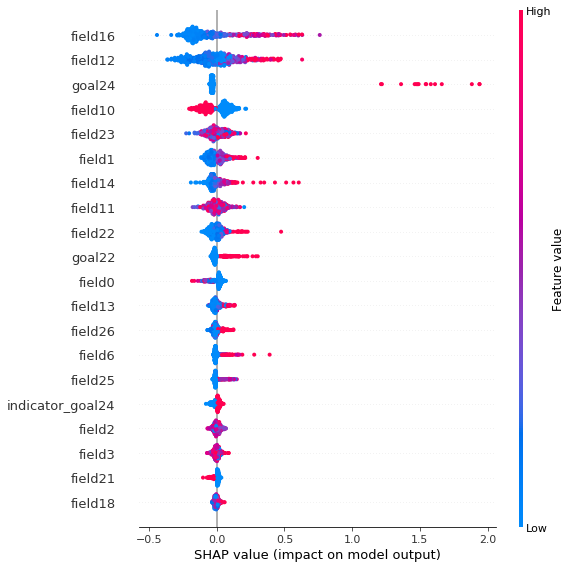

In [15]:
fig = model_class.shap_summary_plot(test)